https://github.com/pranavphoenix/BiLSTM-POS-Tagging/blob/main/BiLSTM_POS_Tagging.ipynb

https://linguistics.stackexchange.com/questions/16897/unable-to-understand-meaning-of-tag-none-1-in-penn-treebank-example

TODO:
- Cacasburo
- Guardare creazione dizionario, bisogna rispettare i punti dell'assignment;
- Non togliere punctuation e symbols ma evitare di utilizzarli nel calcolo delle metriche, magari utilizzando l'array di pesi 'sample_weight' che si trova nell'altro notebook;
- Provare se i risultati migliorano con preprocessing (e.g. lowerando le parole);
- Aggiustare il notebook perché fa cagare;

# Assignment 1

**Due to**: 11/01/2022 (dd/mm/yyyy)

If you deliver it by 11/12/2021 your assignment will be graded by 11/01/2022.


**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures

# Execution
## 0.1 Imports

In [2]:
import nltk
import numpy as np
import os
import re
import pandas as pd
import seaborn as sns
import tensorflow as tf
from collections import defaultdict, OrderedDict


from keras import backend as K
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, GRU
from keras.layers import Embedding, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import urllib.request
import zipfile
import progressbar
from IPython.display import display_html
from itertools import chain,cycle
import plotly.graph_objs as go

## 0.2 Functions

In [3]:
# Preprocessing of words
def pre_process(df,string):
    def text_pre_process(text):
        ret = re.sub('RT @(.)+?:\s|(&#[0-9]+;)|@([\w\-]+)|(#)\S+|(http)s?\S+|&gt;|^\s+|\b\s+|\n', '', text)
        ret = re.sub('\s\s+|[^a-zA-Z\d\s:]' , ' ', ret).rstrip().lower()
        return ret
    return df[string].apply(text_pre_process)

# Downloading Glove Word Embeddings
pbar = None
def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

# Display dataframes
def display(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:left"><td style="vertical-align:top">'
        html_str+=f'<h4 style="text-align: left;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)


# Custom accuracy metric
def ignore_class_accuracy(classes=[0]):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
        
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32')
        for to_ignore in classes:
          ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
          matches = matches * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

# Metrics computation
def compute_metrics(predicted_labels, tags_test, ignore, y_ref, index2tag):
  true_pos = defaultdict(int)
  false_pos = defaultdict(int)
  false_neg = defaultdict(int)
  precision = defaultdict(float)
  recall = defaultdict(float)
  f1score = defaultdict(float)

  for tag in tags_test:
    if tag not in ignore:
      for idx_sentence in range(len(y_ref)):
        for idx_word in range(PAD_LENGTH):
          if index2tag[y_ref[idx_sentence][idx_word]] == tag:
            # If the predicted tag matches ground truth we increase true positive count for that tag
            if predicted_labels[idx_sentence][idx_word] == y_ref[idx_sentence][idx_word]:
              true_pos[index2tag[y_ref[idx_sentence][idx_word]]] += 1
            else:
            # If the predicted tag does not match ground truth we increase false negative count for that tag
            # and false positive count for the wrongly predicted tag
              false_neg[index2tag[y_ref[idx_sentence][idx_word]]] += 1
              false_pos[index2tag[predicted_labels[idx_sentence][idx_word]]] += 1
      # Then we compute precision, recall and F1 scores
      if true_pos[tag] != 0:
        precision[tag] = true_pos[tag] / (true_pos[tag] + false_pos[tag])
        recall[tag] = true_pos[tag] / (true_pos[tag] + false_neg[tag])
        f1score[tag] = 2 * ((precision[tag] * recall[tag]) / (precision[tag] + recall[tag])) 
      else:
        print(f'No true positive for tag: {tag}')
        print(true_pos[tag])
        print(false_pos[tag])
        print(false_neg[tag])
        print()
  return true_pos, false_pos, false_neg, precision, recall, f1score

# Macro f1 score
def macro_f1_score(f1score):
  f1_list = [el[1] for el in f1score.items()]

  sum = 0

  for p in f1_list:
    sum += p
  macro_f1 = sum / len(f1score.items())
  print(f'MACRO F1-score:',macro_f1)

  return macro_f1

# Vocabulary update
def update_vocab(df,embeddings_index,embedding_dim):
  oov_c = 0
  dict_words = list(embeddings_index.keys())

  for idx,row in df.iterrows():
    if row['word'] not in dict_words:
      same_w = 0

      words_with_same_tag = list(df[df.tag == row['tag']]['word'])[:100]
      oov_vector = np.zeros(embedding_dim)
      for w in words_with_same_tag:
        if w in dict_words:
          same_w += 1
          oov_vector += embeddings_index[w]

      oov_vector = oov_vector/same_w

      # words_with_same_tag = [w for w in words_with_same_tag if w in list(embeddings_index.keys())]
      # print(len(words_with_same_tag))
      
      # random_embed = np.random.rand(embedding_dim)
      # embeddings_index[word] = random_embed
      embeddings_index[word] = oov_vector
  print("Added",oov_c,"OOV words + respective embeddings to the vocabulary.")
  return embeddings_index

In [4]:
# Downloading the dataset
nltk.download('treebank')

# Download the GloVe embeddings file
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
urllib.request.urlretrieve(url, 'glove.6B.zip', show_progress)

# Extract the zip file
zip_ref = zipfile.ZipFile('glove.6B.zip', 'r')
zip_ref.extractall()
zip_ref.close()

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
100% (862182613 of 862182613) |##########| Elapsed Time: 0:02:39 Time:  0:02:39


## 1. Corpus
### 1.1 Pre-processing

From the original tags list we removed all the symbols and english punctuation plus:
- FW, Foreign Word, because there are no examples in the test set;
- UH, Interjection, because there are no examples in the test set;
- LS, List Item Marker, because there are no examples in the test set (and because it denotes symbols as well);

In [5]:
# Get the files' list
fileids = nltk.corpus.treebank.fileids()

# Get the Penn Treebank tagged sentences
train_corpus = nltk.corpus.treebank.tagged_sents(fileids[:100])
val_corpus = nltk.corpus.treebank.tagged_sents(fileids[100:150])
test_corpus = nltk.corpus.treebank.tagged_sents(fileids[150:])

# Flatten the lists

train_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(train_corpus) for item in sublist if item[1] != '-NONE-']
val_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(val_corpus) for item in sublist if item[1] != '-NONE-']
test_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(test_corpus) for item in sublist if item[1] != '-NONE-']

# train_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(train_corpus) for item in sublist if item[1] not in ignore]
# val_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(val_corpus) for item in sublist if item[1] not in ignore]
# test_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(test_corpus) for item in sublist if item[1] not in ignore]

#train_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(train_corpus) for item in sublist]
#val_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(val_corpus) for item in sublist]
#test_corpus = [tuple(list(item)+[str(idx)]) for idx,sublist in enumerate(test_corpus) for item in sublist]

train_df = pd.DataFrame(train_corpus, columns = ['word', 'tag', 'sentence'])
#train_df['word'] = train_df['word'].str.lower()
# train_df['word'] = pre_process(train_df,'word')

val_df = pd.DataFrame(val_corpus, columns = ['word', 'tag', 'sentence'])
#val_df['word'] = val_df['word'].str.lower()
# val_df['word'] = pre_process(val_df,'word')

test_df = pd.DataFrame(test_corpus, columns = ['word', 'tag', 'sentence'])
#test_df['word'] = test_df['word'].str.lower()
# test_df['word'] = pre_process(test_df,'word')

display(train_df.describe(), val_df.describe(), test_df.describe(), titles = [f'Training set {train_df.shape}', f'Validation set {val_df.shape}', f'Test set {test_df.shape}'])

,word,tag,sentence
count,47356,47356,47356
unique,8009,45,1963
top,",",NN,1854
freq,2570,6270,249
,word,tag,sentence
count,31183,31183,31183
unique,5892,44,1299
top,",",NN,339
freq,1528,4513,81
,word,tag,sentence


In [ ]:
#lowercase to all classes but NNS and NNPS

#for index, row in train_df.iterrows():
#  if row['tag'] != 'NNP' or 'NNPS':
#    row['word'] = row['word'].lower()
#
#for index, row in val_df.iterrows():
#  if row['tag'] != 'NNP' or 'NNPS':
#     row['word'] = row['word'].lower()

# for index, row in test_df.iterrows():
#   if row['tag'] != 'NNP' or 'NNPS':
#     row['word'] = row['word'].lower()

In [6]:
tags_train = sorted(list(set([x for x in train_df.tag])))
tags_val = sorted(list(set([x for x in val_df.tag])))
tags_test = sorted(list(set([x for x in test_df.tag])))

max_tags_list = max([len(tags_train),len(tags_val),len(tags_test)])

# Training set tags list
print(f'Train tags number: {len(tags_train)}')
print(f'Train tags list: {tags_train}')

exceeding_validation = [el for el in tags_train if el not in tags_val]
if exceeding_validation != []:
  print(f'\tClasses in training set for which there are no samples in validation set: {exceeding_validation}')

exceeding_test = [el for el in tags_train if el not in tags_test]

if exceeding_test != []:
  print(f'\tClasses in training set for which there are no samples in test set: {exceeding_test}')


# Validation set tags list
print(f'\nValidation tags number: {len(tags_val)}')
print(f'Validation tags list: {tags_val}')

exceeding_training = [el for el in tags_val if el not in tags_train]
if exceeding_training != []:
  print(f'\tClasses in validation set for which there are no samples in training set: {exceeding_training}')

exceeding_test = [el for el in tags_val if el not in tags_test]
if exceeding_test != []:
  print(f'\tClasses in validation set for which there are no samples in test set: {exceeding_test}')

# Validation set tags list
print(f'\nTest tags number: {len(tags_test)}')
print(f'Test tags list: {tags_test}')

exceeding_training = [el for el in tags_test if el not in tags_train]
if exceeding_training != []:
  print(f'\tClasses in test set for which there are no samples in training set: {exceeding_training}')

exceeding_val = [el for el in tags_test if el not in tags_val]
if exceeding_val != []:
  print(f'\tClasses in test set set for which there are no samples in validation set: {exceeding_val}')

conf_mat_df = pd.DataFrame(columns=tags_train, index=tags_train)
conf_mat_df = conf_mat_df.fillna(0)

Train tags number: 45
Train tags list: ['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
	Classes in training set for which there are no samples in validation set: ['SYM']
	Classes in training set for which there are no samples in test set: ['#', 'FW', 'LS', 'SYM', 'UH']

Validation tags number: 44
Validation tags list: ['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']
	Classes in validation set for which there are no samples in test set: ['#', 'FW', 'LS', 'UH']

Test tags number: 40
Test tags list: ['$', "''", ',

In [7]:
print(train_df['tag'].value_counts())

NN       6270
NNP      5202
IN       4952
DT       4076
NNS      3004
JJ       2992
,        2571
.        1959
VBD      1548
RB       1490
CD       1439
VB       1195
CC       1141
VBZ      1133
VBN      1031
TO       1028
PRP       954
VBG       763
VBP       727
MD        413
PRP$      409
``        409
POS       403
''        399
$         342
:         293
WDT       204
JJR       157
WP        141
RP        140
NNPS       95
JJS        93
WRB        92
RBR        86
-RRB-      55
-LRB-      52
EX         49
RBS        19
LS         10
PDT         9
WP$         6
FW          2
UH          1
SYM         1
#           1
Name: tag, dtype: int64


In [8]:
# Retriving prepocessed data
X_train_raw = train_df.groupby('sentence').word.apply(list).reset_index()['word']
X_val_raw = val_df.groupby('sentence').word.apply(list).reset_index()['word']
X_test_raw = test_df.groupby('sentence').word.apply(list).reset_index()['word']

y_train_raw = train_df.groupby('sentence').tag.apply(list).reset_index()['tag']
y_val_raw = val_df.groupby('sentence').tag.apply(list).reset_index()['tag']
y_test_raw = test_df.groupby('sentence').tag.apply(list).reset_index()['tag']

##-Vocabulary part-

GloVe Vocabulary (V1)

In [43]:
#Use the 300 dimensional GLove Word Embeddings
glove_dir = './'
embedding_dim = 300
embedding_dict = {} #initialize dictionary
f = open(os.path.join(glove_dir, f'glove.6B.{embedding_dim}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_dict))

Found 400000 word vectors.


In [44]:
tag_dict = {tag:np.zeros(embedding_dim) for tag in tags_train}
tag_count = {tag:0 for tag in tags_train}

for idx, row in train_df.iterrows():
  for tag in tags_train:
    if tag == row['tag']:
      if row['word'] in embedding_dict:
          tag_count[tag] += 1
          tag_dict[tag] += embedding_dict[row['word']]

for tag in tags_train:
  if np.all(tag_dict[tag]):
    tag_dict[tag] = tag_dict[tag] / tag_count[tag]

V1 + Training set OOV (V2)

In [45]:
def update_vocab(df,embeddings_index,embedding_dim): 
  oov_c = 0 
  # for word in df.word: 
  for idx, row in df.iterrows(): 
    if row['word'].lower() not in embeddings_index: 
      oov_c += 1
      embeddings_index[row['word']] = tag_dict[row['tag']]       
    else: 
      embeddings_index[row['word']] = embeddings_index[row['word'].lower()]  
  print("Added",oov_c,"OOV words + respective embeddings to the vocabulary.") 
  return embeddings_index

embedding_dict = update_vocab(train_df,embedding_dict,embedding_dim)

Added 555 OOV words + respective embeddings to the vocabulary.


V2 + Validation set OOV (V3)

In [46]:
embedding_dict = update_vocab(val_df,embedding_dict,embedding_dim)

Added 305 OOV words + respective embeddings to the vocabulary.


V3 + Test set OOV (V4)

In [47]:
embedding_dict = update_vocab(test_df,embedding_dict,embedding_dim)

Added 214 OOV words + respective embeddings to the vocabulary.


In [48]:
#Building the actual word vocabulary

index2word = OrderedDict()
word2index = OrderedDict()

curr_idx = 0
for key in embedding_dict.keys():
  word2index[key] = curr_idx
  index2word[curr_idx] = key
  curr_idx += 1

vocab_length = len(word2index) 
print(f'[Debug] Index -> Word vocabulary size: {len(index2word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word2index)}')

[Debug] Index -> Word vocabulary size: 403745
[Debug] Word -> Index vocabulary size: 403745


In [49]:
#Tag vocabulary

tag2index = OrderedDict()
index2tag = OrderedDict()

curr_id = 0
for tag in tags_train:
  tag2index[tag] = curr_id
  index2tag[curr_id] = tag
  curr_id += 1

print(f'[Debug] Index -> Tag vocabulary size: {len(index2tag)}')
print(f'[Debug] Tag -> Index vocabulary size: {len(tag2index)}')


[Debug] Index -> Tag vocabulary size: 45
[Debug] Tag -> Index vocabulary size: 45


###da qua continua il preprocessing

In [50]:
# Tokenising words and tags by their indexes in vocabulary
X_train_np, X_val_np, X_test_np, y_train_np, y_val_np, y_test_np = [], [], [], [], [], []

# Encode X
for sentence in X_train_raw:
    sent_int = []
    for word in sentence:
            sent_int.append(word2index[word])
    X_train_np.append(sent_int)

for sentence in X_val_raw:
    sent_int = []
    for word in sentence:
            sent_int.append(word2index[word])
    X_val_np.append(sent_int)

for sentence in X_test_raw:
    sent_int = []
    for word in sentence:
            sent_int.append(word2index[word])
    X_test_np.append(sent_int)

# Encode Y
for sent_tags in y_train_raw:
    y_train_np.append([tag2index[tag] for tag in sent_tags])

for sent_tags in y_val_raw:
    y_val_np.append([tag2index[tag] for tag in sent_tags])

for sent_tags in y_test_raw:
    y_test_np.append([tag2index[tag] for tag in sent_tags])

print('-Not encoded')
print('\t',X_train_raw[0]) 
print('\t',y_train_raw[0])
print('-Encoded')
print('\t',X_train_np[0])
print('\t',y_train_np[0])

-Not encoded
	 ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
	 ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']
-Encoded
	 [400000, 400001, 1, 4978, 82, 167, 1, 43, 1429, 0, 534, 19, 7, 128564, 369, 400002, 1263, 2]
	 [20, 20, 3, 9, 22, 14, 3, 18, 34, 10, 19, 13, 10, 14, 19, 20, 9, 6]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


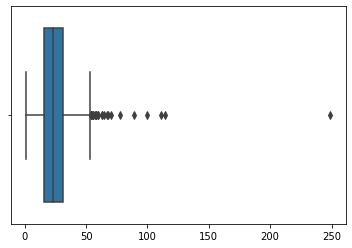

In [51]:
lengths = [len(sentence) for sentence in X_train_raw]
lengths.sort()

sns.boxplot(lengths)

In [52]:
MAX_LENGTH = lengths[-1] # maximum words in a sentence

PAD_LENGTH = lengths[-2]


print(f'Length of longest sentence: {MAX_LENGTH}')
print(f'Second longest sentence length: {PAD_LENGTH}')


X_train = pad_sequences(X_train_np, maxlen=PAD_LENGTH, padding='post')
X_val = pad_sequences(X_val_np, maxlen=PAD_LENGTH, padding='post')
X_test = pad_sequences(X_test_np, maxlen=PAD_LENGTH, padding='post')

y_train = pad_sequences(y_train_np, maxlen=PAD_LENGTH, padding='post')
y_val = pad_sequences(y_val_np, maxlen=PAD_LENGTH, padding='post')
y_test = pad_sequences(y_test_np, maxlen=PAD_LENGTH, padding='post')
print('-Padded')
print('\tX:',X_train[0])
print('\n\ty:',y_train[0])

# List of tags to ignore
ignore = [':', '#', '$', '-LRB-', '-RRB-', ',', '.', "''", '``', 'SYM']


Length of longest sentence: 249
Second longest sentence length: 114
-Padded
	X: [400000 400001      1   4978     82    167      1     43   1429      0
    534     19      7 128564    369 400002   1263      2      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]

	y: [20 20  3  9 22 14  3 18 34 10 19 13 10 14 19 20  9  6  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 

In [53]:
y_train_one_hot = to_categorical(y_train, len(tag2index))
y_val_one_hot = to_categorical(y_val, len(tag2index))
y_test_one_hot = to_categorical(y_test, len(tag2index))

## 2. GloVe 
GloVe (Global Vectors for Word Representation) is a method for learning vector representations of words, called "word embeddings," from a large corpus of text. Word embeddings are numerical representations of words that capture the semantic relationships between words in a continuous, low-dimensional space. They are commonly used as input to natural language processing models, such as language translation and language modeling.

GloVe works by learning the co-occurrence statistics of words in a corpus, and using this information to learn word embeddings that capture the semantic relationships between words. The GloVe method produces word embeddings that are trained on a global corpus, as opposed to embeddings that are trained on a specific task or dataset.

There are different versions of the GloVe word embeddings, including 50-dimensional, 100-dimensional, and 200-dimensional embeddings. The 50-dimensional version of GloVe embeddings may be better in some applications because they have a lower dimensionality, which can make them easier to work with and more computationally efficient.

By using GloVe embeddings as the initial weights for a model, we can take advantage of these pre-trained word representations and fine-tune them for a specific task.

In [54]:
#Building the Embedding Layer 
embedding_matrix = np.zeros((len(word2index), embedding_dim))
# embedding_matrix = np.standard(0,1,(len(word2index), embedding_dim))
for word, i in word2index.items():
    embedding_vector = embedding_dict.get(word)
    if i < len(word2index):
      embedding_matrix[i] = embedding_vector

## 3. Model
### 3.1 Baseline 
Bidirectional LSTM layers are able to process sequential data in both the forward and backward directions, which can allow the model to capture contextual information from both the past and the future. This can be particularly useful for natural language processing tasks, where the meaning of a word can depend on the context in which it is used.

In the context of POS tagging, TimeDistributed can be used to apply a tag prediction layer to each word in a sentence. For example, you might have an RNN that processes a sequence of words in a sentence, and at each time step, the RNN outputs a hidden state. You could then apply a TimeDistributed dense layer to the hidden states, which would allow you to predict the POS tag for each word in the sentence.

One advantage of using TimeDistributed for POS tagging is that it allows you to predict the POS tag for each word in the sentence simultaneously, rather than having to process the sentence one word at a time. This can be particularly useful when dealing with long sentences, as it can make the tagging process more efficient.

Overall, using TimeDistributed for POS tagging can help you build more accurate and efficient models for natural language processing tasks that involve sequential data.

In [56]:
# Define the model
baseline_model = Sequential(name='Baseline')

# Add the Embedding layer
baseline_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
                    weights=[embedding_matrix], input_length=PAD_LENGTH, trainable=False,mask_zero=True))

# Add the Bidirectional LSTM layer
baseline_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add the Dense/Fully-Connected layer
baseline_model.add(TimeDistributed(Dense(units=len(tag2index), activation='softmax')))

# Compile the model
baseline_model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy',\
                      ignore_class_accuracy([tag2index[tag] for tag in ignore])])

# Summary
baseline_model.summary()
 
# Callbacks 
callbacks = [ 
    tf.keras.callbacks.EarlyStopping(monitor='val_ignore_accuracy', patience=3, restore_best_weights=True,verbose=True), 
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_ignore_accuracy', factor=0.5, patience=1, verbose=True, min_lr=0.001) 
]

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 114, 300)          121123500 
                                                                 
 bidirectional_1 (Bidirectio  (None, 114, 512)         1140736   
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 114, 45)          23085     
 tributed)                                                       
                                                                 
Total params: 122,287,321
Trainable params: 1,163,821
Non-trainable params: 121,123,500
_________________________________________________________________


In [57]:
results_baseline = baseline_model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),\
                                      batch_size=128, epochs=15, callbacks = callbacks)

Epoch 1/15
16/16 [==============================] - 54s 3s/step - loss: 0.3958 - accuracy: 0.4994 - ignore_accuracy: 0.0814 - val_loss: 0.1650 - val_accuracy: 0.7688 - val_ignore_accuracy: 0.1303 - lr: 0.0100
Epoch 2/15
16/16 [==============================] - 38s 2s/step - loss: 0.1155 - accuracy: 0.8368 - ignore_accuracy: 0.1430 - val_loss: 0.0984 - val_accuracy: 0.8578 - val_ignore_accuracy: 0.1482 - lr: 0.0100
Epoch 3/15
16/16 [==============================] - 39s 2s/step - loss: 0.0675 - accuracy: 0.9035 - ignore_accuracy: 0.1566 - val_loss: 0.0805 - val_accuracy: 0.8796 - val_ignore_accuracy: 0.1523 - lr: 0.0100
Epoch 4/15
16/16 [==============================] - 39s 2s/step - loss: 0.0446 - accuracy: 0.9368 - ignore_accuracy: 0.1629 - val_loss: 0.0660 - val_accuracy: 0.9003 - val_ignore_accuracy: 0.1564 - lr: 0.0100
Epoch 5/15
16/16 [==============================] - 38s 2s/step - loss: 0.0280 - accuracy: 0.9630 - ignore_accuracy: 0.1681 - val_loss: 0.0629 - val_accuracy: 0.907

In [58]:
scores_bl = baseline_model.evaluate(X_val, y_val_one_hot, return_dict = True)

# Obtain the predictions made by the model on the validation set
predictions_bl = baseline_model.predict(X_val)

41/41 [==============================] - 14s 259ms/step


In [59]:
# Convert the class probabilities into class labels
predicted_labels_bl = np.argmax(predictions_bl, axis=-1)

true_pos_bl, false_pos_bl, false_neg_bl, precision_bl, recall_bl, f1score_bl = compute_metrics(predicted_labels_bl, tags_test, ignore, y_val, index2tag)

In [60]:
# FORSE DOBBIAMO CONSIDERARE TUTTE LE CLASSI; ANCHE QUELLE PRESENTI SOLO NEL TRAINING TEST, DANDO COME f1 SCORE 0
for tag in tags_val:
  if tag not in ignore:
    print(f'Tag: {tag}')
    print(f'\tPrecision: {precision_bl[tag]}')
    print(f'\tRecall: {recall_bl[tag]}')
    print(f'\tF1-score: {f1score_bl[tag]}')

Tag: CC
	Precision: 1.0
	Recall: 0.9841688654353562
	F1-score: 0.9920212765957447
Tag: CD
	Precision: 0.9983539094650206
	Recall: 0.9711769415532426
	F1-score: 0.9845779220779222
Tag: DT
	Precision: 1.0
	Recall: 0.46949891067538124
	F1-score: 0.6389918458117123
Tag: EX
	Precision: 1.0
	Recall: 1.0
	F1-score: 1.0
Tag: FW
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: IN
	Precision: 0.9968233799237611
	Recall: 0.9581679389312977
	F1-score: 0.9771134983652497
Tag: JJ
	Precision: 0.9936224489795918
	Recall: 0.8097713097713097
	F1-score: 0.8923253150057274
Tag: JJR
	Precision: 0.9929577464788732
	Recall: 0.8545454545454545
	F1-score: 0.9185667752442996
Tag: JJS
	Precision: 0.9791666666666666
	Recall: 0.8103448275862069
	F1-score: 0.8867924528301887
Tag: LS
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Tag: MD
	Precision: 1.0
	Recall: 0.9855907780979827
	F1-score: 0.9927431059506531
Tag: NN
	Precision: 0.9513179767276182
	Recall: 0.8876578772435187
	F1-score: 0.9183860614397066
Tag: NNP
	Pre

In [61]:
macro_f1_bl = macro_f1_score(f1score_bl)

MACRO F1-score: 0.7722604572649779


### 3.2 GRU 
Gated Recurrent Units (GRUs) are a type of recurrent neural network (RNN) that are often used in natural language processing tasks such as part-of-speech (POS) tagging. GRUs are similar to long short-term memory (LSTM) networks, but they have a simpler structure and fewer parameters, making them easier to train and faster to run. In POS tagging, GRUs can be used to process a sequence of words and predict the POS tags for each word in the sequence. GRUs are able to take into account contextual information from the previous words in the sequence, allowing them to make more accurate predictions about the POS tags for the current word. 

Both BiLSTMs (Bidirectional LSTMs) and Gated Recurrent Units (GRUs) have been shown to perform well on a variety of NLP tasks, including POS tagging, but here we obtained slightly better results than with the baseline; the reason may be that LSTMs are are particularly well-suited for tasks that require the model to remember and make use of long-term dependencies in the data, while the longest sentence in the Penn Treebank dataset has only 171 words and the average of words per sentence is around 20.  

In [63]:
# Define the model
gru_model = tf.keras.Sequential(name='GRU')

# Add the Embedding layer
gru_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
                    weights = [embedding_matrix], input_length = PAD_LENGTH, trainable=False,mask_zero=True ))

# Add the GRU layer
gru_model.add(GRU(units=256, return_sequences=True))

# Add the Dense/Fully-Connected layer
gru_model.add(TimeDistributed(Dense(len(tags_train), activation='softmax')))

# Compile the model
gru_model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([tag2index[tag] for tag in ignore])])

# Summary
gru_model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 114, 300)          121123500 
                                                                 
 gru_1 (GRU)                 (None, 114, 256)          428544    
                                                                 
 time_distributed_3 (TimeDis  (None, 114, 45)          11565     
 tributed)                                                       
                                                                 
Total params: 121,563,609
Trainable params: 440,109
Non-trainable params: 121,123,500
_________________________________________________________________


In [64]:
results_gru = gru_model.fit(X_train, y_train_one_hot, epochs=15, verbose = True, \
                            validation_data=(X_val, y_val_one_hot), batch_size=128, callbacks = callbacks)

Epoch 1/15
16/16 [==============================] - 21s 1s/step - loss: 0.3065 - accuracy: 0.6045 - ignore_accuracy: 0.1001 - val_loss: 0.1456 - val_accuracy: 0.7905 - val_ignore_accuracy: 0.1347 - lr: 0.0100
Epoch 2/15
16/16 [==============================] - 15s 960ms/step - loss: 0.1082 - accuracy: 0.8451 - ignore_accuracy: 0.1446 - val_loss: 0.1026 - val_accuracy: 0.8498 - val_ignore_accuracy: 0.1464 - lr: 0.0100
Epoch 3/15
16/16 [==============================] - 15s 955ms/step - loss: 0.0732 - accuracy: 0.8941 - ignore_accuracy: 0.1545 - val_loss: 0.0882 - val_accuracy: 0.8673 - val_ignore_accuracy: 0.1499 - lr: 0.0100
Epoch 4/15
16/16 [==============================] - 15s 960ms/step - loss: 0.0534 - accuracy: 0.9221 - ignore_accuracy: 0.1600 - val_loss: 0.0798 - val_accuracy: 0.8811 - val_ignore_accuracy: 0.1526 - lr: 0.0100
Epoch 5/15
16/16 [==============================] - 15s 963ms/step - loss: 0.0393 - accuracy: 0.9443 - ignore_accuracy: 0.1645 - val_loss: 0.0756 - val_acc

In [65]:
scores_gru = gru_model.evaluate(X_val, y_val_one_hot, return_dict = True)
predictions_gru = gru_model.predict(X_val)

41/41 [==============================] - 6s 109ms/step


In [66]:
# Convert the class probabilities into class labels
predicted_labels_gru = np.argmax(predictions_gru, axis=-1)

true_pos_gru, false_pos_gru, false_neg_gru, precision_gru, recall_gru, f1score_gru = compute_metrics(predicted_labels_gru, tags_test, ignore, y_val, index2tag)


In [67]:
macro_f1_gru = macro_f1_score(f1score_gru)

MACRO F1-score: 0.8118727890733606


### 3.3 Additional LSTM layer 
Using two BiLSTMs layers can allow the model to learn more complex patterns in the data and make more accurate predictions. 
However, they can increase the computational complexity of our model, which may require more computational resources to train.

With the same number of epochs the results were similar to the baseline and the training process was slower; it is possible that the model with two BiLSTMs is more prone to overfitting, meaning that it is able to fit the training data very well but is less able to generalize to new data. Another possibility is that the model with two BiLSTMs simply takes longer to train. That is why we raised the training epochs to 20, obtaining better results.

In [68]:
# Define the model
add_lstm_model = tf.keras.Sequential(name='Additional_LSTM')

# Add the Embedding layer
add_lstm_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
                    weights = [embedding_matrix], input_length = PAD_LENGTH, trainable=False, mask_zero=True))

# Add the Bidirectional LSTM layer
add_lstm_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add another LSTM layer
add_lstm_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add the Dense/Fully-Connected layer
add_lstm_model.add(TimeDistributed(Dense(units=len(tags_train), activation='softmax')))

# Compile the model
add_lstm_model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([tag2index[tag] for tag in ignore])])

# Summary
add_lstm_model.summary()

Model: "Additional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 114, 300)          121123500 
                                                                 
 bidirectional_2 (Bidirectio  (None, 114, 512)         1140736   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 114, 512)         1574912   
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 114, 45)          23085     
 tributed)                                                       
                                                                 
Total params: 123,862,233
Trainable params: 2,738,733
Non-trainable params: 121,123,500
_____________________________

In [69]:
results_add_lstm = add_lstm_model.fit(X_train, y_train_one_hot, epochs=20, verbose = True, \
                                      validation_data=(X_val, y_val_one_hot), batch_size=128, callbacks = callbacks)

Epoch 1/20
16/16 [==============================] - 127s 7s/step - loss: 0.6777 - accuracy: 0.1648 - ignore_accuracy: 0.0284 - val_loss: 0.4858 - val_accuracy: 0.3303 - val_ignore_accuracy: 0.0511 - lr: 0.0100
Epoch 2/20
16/16 [==============================] - 98s 6s/step - loss: 0.3556 - accuracy: 0.5015 - ignore_accuracy: 0.0795 - val_loss: 0.2508 - val_accuracy: 0.6584 - val_ignore_accuracy: 0.1101 - lr: 0.0100
Epoch 3/20
16/16 [==============================] - 96s 6s/step - loss: 0.1834 - accuracy: 0.7517 - ignore_accuracy: 0.1269 - val_loss: 0.1451 - val_accuracy: 0.7995 - val_ignore_accuracy: 0.1367 - lr: 0.0100
Epoch 4/20
16/16 [==============================] - 96s 6s/step - loss: 0.1088 - accuracy: 0.8506 - ignore_accuracy: 0.1459 - val_loss: 0.1127 - val_accuracy: 0.8369 - val_ignore_accuracy: 0.1441 - lr: 0.0100
Epoch 5/20
16/16 [==============================] - 95s 6s/step - loss: 0.0749 - accuracy: 0.8944 - ignore_accuracy: 0.1546 - val_loss: 0.0843 - val_accuracy: 0.87

In [70]:
scores_add_lstm = add_lstm_model.evaluate(X_val, y_val_one_hot, return_dict = True)
predictions_add_lstm = add_lstm_model.predict(X_val)

41/41 [==============================] - 32s 637ms/step


In [71]:
# Convert the class probabilities into class labels
predicted_labels_add_lstm = np.argmax(predictions_add_lstm, axis=-1)

true_pos_add_lstm, false_pos_add_lstm, false_neg_add_lstm, precision_add_lstm, recall_add_lstm, f1score_add_lstm = compute_metrics(predicted_labels_add_lstm, tags_test, ignore, y_val, index2tag)


No true positive for tag: PDT
0
0
14



In [72]:
macro_f1_add_lstm = macro_f1_score(f1score_add_lstm)

MACRO F1-score: 0.8820647810182816


### 3.4 Additional dense layer

Using two dense layers, one with a non-linear activation function and one with a softmax activation function, is a common pattern in neural network architectures for classification tasks.

The purpose of the non-linear dense layer is to introduce non-linearity into the model, which can allow the model to learn more complex patterns in the data. Common choices for the activation function in this layer include ReLU (Rectified Linear Unit), sigmoid, and tanh.

The purpose of the softmax dense layer is to produce a probability distribution over the possible classes. The softmax activation function transforms the output of the preceding layer into a probability distribution, where the sum of the probabilities is equal to 1. This is useful for classification tasks, where you want to predict the probability that an input belongs to each of the possible classes. Using two dense layers in this way can allow the model to learn more complex patterns in the data and make more accurate predictions.

We have increased the number of training epochs to 15 for the same reasons as before.

In [73]:
# Define the model
add_fc_model = tf.keras.Sequential(name='Additional_FC')

# Add the Embedding layer
add_fc_model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, \
                    weights = [embedding_matrix], input_length = PAD_LENGTH, trainable=False, mask_zero=True))

# Add the Bidirectional LSTM layer
add_fc_model.add(Bidirectional(LSTM(units=256, return_sequences=True)))

# Add another Dense layer
add_fc_model.add(TimeDistributed(Dense(units=PAD_LENGTH, activation='relu')))

# Add the Dense/Fully-Connected layer
add_fc_model.add(TimeDistributed(Dense(units=len(tags_train), activation='softmax')))

# Compile the model
add_fc_model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy',ignore_class_accuracy([tag2index[tag] for tag in ignore])])

# Summary
add_fc_model.summary()

Model: "Additional_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 114, 300)          121123500 
                                                                 
 bidirectional_4 (Bidirectio  (None, 114, 512)         1140736   
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 114, 114)         58482     
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 114, 45)          5175      
 tributed)                                                       
                                                                 
Total params: 122,327,893
Trainable params: 1,204,393
Non-trainable params: 121,123,500
_______________________________

In [74]:
results_add_fc = add_fc_model.fit(X_train, y_train_one_hot, epochs=20, verbose = True, \
                                  validation_data=(X_val, y_val_one_hot), batch_size=128, callbacks = callbacks)

Epoch 1/20
16/16 [==============================] - 53s 3s/step - loss: 0.4667 - accuracy: 0.3853 - ignore_accuracy: 0.0638 - val_loss: 0.2140 - val_accuracy: 0.7193 - val_ignore_accuracy: 0.1217 - lr: 0.0100
Epoch 2/20
16/16 [==============================] - 39s 2s/step - loss: 0.1438 - accuracy: 0.8046 - ignore_accuracy: 0.1368 - val_loss: 0.1099 - val_accuracy: 0.8463 - val_ignore_accuracy: 0.1458 - lr: 0.0100
Epoch 3/20
16/16 [==============================] - 39s 2s/step - loss: 0.0739 - accuracy: 0.8976 - ignore_accuracy: 0.1552 - val_loss: 0.0803 - val_accuracy: 0.8845 - val_ignore_accuracy: 0.1535 - lr: 0.0100
Epoch 4/20
16/16 [==============================] - 39s 2s/step - loss: 0.0438 - accuracy: 0.9381 - ignore_accuracy: 0.1634 - val_loss: 0.0662 - val_accuracy: 0.9028 - val_ignore_accuracy: 0.1570 - lr: 0.0100
Epoch 5/20
16/16 [==============================] - 39s 2s/step - loss: 0.0258 - accuracy: 0.9644 - ignore_accuracy: 0.1685 - val_loss: 0.0623 - val_accuracy: 0.913

In [75]:
scores_add_fc = add_fc_model.evaluate(X_val, y_val_one_hot, return_dict = True)
predictions_add_fc = add_fc_model.predict(X_val)

41/41 [==============================] - 14s 270ms/step


In [76]:
# Convert the class probabilities into class labels
predicted_labels_add_fc = np.argmax(predictions_add_fc, axis=-1)

true_pos_add_fc, false_pos_add_fc, false_neg_add_fc, precision_add_fc, recall_add_fc, f1score_add_fc = compute_metrics(predicted_labels_add_fc, tags_test, ignore, y_val, index2tag)


In [77]:
macro_f1_add_fc = macro_f1_score(f1score_add_fc)

MACRO F1-score: 0.8358757599059193


## 4. Comparisons


In [78]:
# Sample data
data = [macro_f1_bl,macro_f1_gru,macro_f1_add_lstm,macro_f1_add_fc]

# Create figure
fig = go.Figure(data=[go.Bar(x=['Baseline','GRU', 'Add. LSTM', 'Add. FC'], y=data)])

# Set titles for axes
fig.update_layout(xaxis_title='Models', yaxis_title='Macro F1')

# Show plot
fig.show()


In [ ]:
print(index2tag)

OrderedDict([(0, '#'), (1, '$'), (2, "''"), (3, ','), (4, '-LRB-'), (5, '-NONE-'), (6, '-RRB-'), (7, '.'), (8, ':'), (9, 'CC'), (10, 'CD'), (11, 'DT'), (12, 'EX'), (13, 'FW'), (14, 'IN'), (15, 'JJ'), (16, 'JJR'), (17, 'JJS'), (18, 'LS'), (19, 'MD'), (20, 'NN'), (21, 'NNP'), (22, 'NNPS'), (23, 'NNS'), (24, 'PDT'), (25, 'POS'), (26, 'PRP'), (27, 'PRP$'), (28, 'RB'), (29, 'RBR'), (30, 'RBS'), (31, 'RP'), (32, 'SYM'), (33, 'TO'), (34, 'UH'), (35, 'VB'), (36, 'VBD'), (37, 'VBG'), (38, 'VBN'), (39, 'VBP'), (40, 'VBZ'), (41, 'WDT'), (42, 'WP'), (43, 'WP$'), (44, 'WRB'), (45, '``')])


In [79]:
#Test phrase
np.random.seed(41)
idx = np.random.randint(0, len(X_val_np))

print(f'Test sentence: {[index2word[word] for word in X_val_np[idx]]}') 

#ground truth
print(f'Ground truth tags: {[index2tag[tag] for tag in y_val_np[idx]]}')

#test bl
print(f'Baseline predictions: {[index2tag[tag] for tag in predicted_labels_bl[idx]]}')
#test gru
print(f'GRU predictions: {[index2tag[tag] for tag in predicted_labels_gru[idx]]}')
#test add lstm
print(f'Additional LSTM layer predictions: {[index2tag[tag] for tag in predicted_labels_add_lstm[idx]]}')
#test add fc
print(f'Additional FC layer predictions: {[index2tag[tag] for tag in predicted_labels_add_fc[idx]]}')



Test sentence: ['The', 'sad', 'reality', 'is', 'that', 'the', 'retail', 'investor', 'continues', 'to', 'pursue', 'stellar', 'performers', 'first', ',', 'while', 'leaving', 'institutions', 'to', 'grapple', 'with', 'basis', 'points', 'of', 'performance', 'on', 'large', 'sums', 'of', 'money', 'quarter', 'by', 'quarter', '.']
Ground truth tags: ['DT', 'JJ', 'NN', 'VBZ', 'IN', 'DT', 'JJ', 'NN', 'VBZ', 'TO', 'VB', 'JJ', 'NNS', 'RB', ',', 'IN', 'VBG', 'NNS', 'TO', 'VB', 'IN', 'NN', 'NNS', 'IN', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'NN', 'NN', 'IN', 'NN', '.']
Baseline predictions: ['DT', 'NN', 'NN', 'VBZ', 'IN', '.', 'JJ', 'NN', 'VBZ', 'TO', 'VB', 'JJ', 'NNS', 'JJ', ',', 'IN', 'VBG', 'NNS', 'TO', 'VB', 'IN', 'JJ', 'NNS', 'IN', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'NN', 'NN', 'IN', 'NN', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '

In [80]:
#Computing macro scores on test set
#Additional LSTM layer
predictions_add_lstm_test = add_lstm_model.predict(X_test)

predicted_labels_add_lstm_test = np.argmax(predictions_add_lstm_test, axis=-1)

true_pos_add_lstm_test, false_pos_add_lstm_test, false_neg_add_lstm_test, precision_add_lstm_test, recall_add_lstm_test, f1score_add_lstm_test = compute_metrics(predicted_labels_add_lstm_test, tags_test, ignore, y_test, index2tag)

macro_f1_add_lstm_test = macro_f1_score(f1score_add_lstm_test)

21/21 [==============================] - 12s 565ms/step
No true positive for tag: PDT
0
0
4

MACRO F1-score: 0.8937388742557075


In [81]:
#Computing macro scores on test set
#Additional FC layer
predictions_add_fc_test = add_fc_model.predict(X_test)

predicted_labels_add_fc_test = np.argmax(predictions_add_fc_test, axis=-1)

true_pos_add_fc_test, false_pos_add_fc_test, false_neg_add_fc_test, precision_add_fc_test, recall_add_fc_test, f1score_add_fc_test = compute_metrics(predicted_labels_add_fc_test, tags_test, ignore, y_test, index2tag)

macro_f1_add_fc_test = macro_f1_score(f1score_add_fc_test)

21/21 [==============================] - 6s 263ms/step
No true positive for tag: PDT
0
0
4

MACRO F1-score: 0.8614731552341435


In [82]:
# # Create a list of epochs (i.e., the x-axis data)
epochs = list(range(1, len(results_baseline.history['val_accuracy'])+1))

# # Create a Plotly line plot using the epochs and validation accuracy data
fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=results_baseline.history['val_accuracy'], name='Baseline - BiLSTM Model', mode='lines+markers'))
fig.add_trace(go.Scatter(x=epochs, y=results_gru.history['val_accuracy'], name='GRU Model', mode='lines+markers'))
fig.show()

# Create a list of epochs (i.e., the x-axis data)
epochs = list(range(1, len(results_add_lstm.history['val_accuracy'])+1))

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=epochs, y=results_add_lstm.history['val_accuracy'], name='2 BiLSTMs Model', mode='lines+markers'))
fig2.add_trace(go.Scatter(x=epochs, y=results_add_fc.history['val_accuracy'], name='2 FCs Model', mode='lines+markers'))
fig2.show()